In [1]:
import sqlite3
import pandas as pd
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import shapiro, anderson
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar as mcnemar2

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('db_files/loggedArbitrationFinal.db')
cursor = conn.cursor()

# GENERAL

## Test for normality

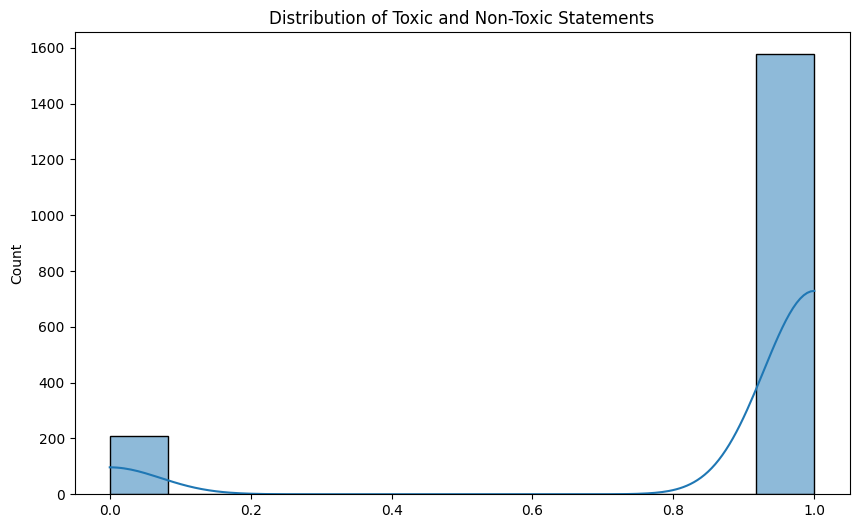

In [14]:
cursor.execute("SELECT COUNT(*) FROM StatementsTable WHERE trueEval = 1")
result = cursor.fetchone()

num_of_toxic = result[0]

cursor.execute("SELECT COUNT(*) FROM StatementsTable WHERE trueEval = 0")
result = cursor.fetchone()

num_of_non_toxic = result[0]
data = [1] * num_of_toxic + [0] * num_of_non_toxic

# Plot a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True)
plt.title('Distribution of Toxic and Non-Toxic Statements')
plt.show()

In [15]:
stat_shapiro, p_shapiro = shapiro(data)
print(f'Shapiro-Wilk Test: Statistic={stat_shapiro}, p-value={p_shapiro}')

alpha = 0.05 

if p_shapiro < alpha:
    print("Reject Normality")
else:
    print("Accept Normality")

Shapiro-Wilk Test: Statistic=0.3737030625343323, p-value=0.0
Reject Normality


## WilCoxon Test

In [4]:
# Fetch data from the database
cursor.execute("SELECT boolChatFilter, boolCNNSVM, trueEval FROM StatementsTable")
data = cursor.fetchall()

# Unpack the data
boolChatFilter, boolCNNSVM, trueEval = zip(*data)

# Convert tuples to lists
boolChatFilter = list(boolChatFilter)
boolCNNSVM = list(boolCNNSVM)
trueEval = list(trueEval)

# Calculate the differences between model predictions
differences = [cnnsvm - chatfilter for cnnsvm, chatfilter in zip(boolCNNSVM, boolChatFilter)]

# Perform the Wilcoxon Signed-Rank Test
w_stat, p_value = wilcoxon(differences)

# Output the p-value
print(f'Wilcoxon Signed-Rank Test p-value: {p_value}')

Wilcoxon Signed-Rank Test p-value: 5.038606992892795e-30


## McNemar Test 

In [3]:
# Assuming you have fetched the data from the database
cursor.execute("SELECT boolChatFilter, boolCNNSVM, trueEval FROM StatementsTable")
data = cursor.fetchall()

# Unpack the data and convert to lists
boolChatFilter, boolCNNSVM, trueEval = zip(*data)

boolChatFilter = np.array(boolChatFilter)
boolCNNSVM = np.array(boolCNNSVM)
trueEval = np.array(trueEval)

tb = mcnemar_table(y_target=trueEval, y_model1=boolChatFilter, y_model2=boolCNNSVM)
print(tb)

threshold = 3.841 
significance_value = 0.05

# McNemar's Test with the continuity correction
test = mcnemar(tb, exact=False, correction=True)

if test.pvalue < significance_value:
  print("Reject Null hypotesis")
else:
  print("Fail to reject Null hypotesis")

[[911 164]
 [382 329]]
Reject Null hypotesis


In [16]:
cursor.execute("SELECT boolChatFilter, boolCNNSVM, trueEval FROM StatementsTable WHERE ((matchID - 1) % 2 = 0 OR MatchId = 6) AND MatchId != 5;")
data = cursor.fetchall()

# Unpack the data and convert to lists
boolChatFilter, boolCNNSVM, trueEval = zip(*data)

boolChatFilter = np.array(boolChatFilter)
boolCNNSVM = np.array(boolCNNSVM)
trueEval = np.array(trueEval)

tb = mcnemar_table(y_target=trueEval, y_model1=boolChatFilter, y_model2=boolCNNSVM)
print(tb)

# calculate mcnemar test
result = mcnemar(tb, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
 print('Same proportions of errors (fail to reject H0)')
else:
 print('Different proportions of errors (reject H0)')

[[496  36]
 [165 164]]
statistic=36.000, p-value=0.000
Different proportions of errors (reject H0)


## EXCEL

### Loading Models

In [ ]:
# Load the Excel file
file_path = 'db_files/loggedArbitration.xlsx'
data = pd.read_excel(file_path)

# Extract features and target
X_test = data['statement']
trueEval = data['trueEval']
y_test = trueEval

max_words = 2000  # Number of unique words to consider
max_sequence_length = 200  # Maximum length of a sequence

tokenizer = joblib.load('output_model/tokenizer_proper_KFOLD.pkl')

# Tokenize and pad sequences using the same tokenizer used during training
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Load the CNN model
loaded_cnn_model = load_model('output_model/cnn_model_proper_KFOLD.h5')

# Extract features from the loaded CNN model
cnn_features_model = Sequential(loaded_cnn_model.layers[:-1])
X_test_cnn_features = cnn_features_model.predict(X_test_padded)

# Load the SVM model
loaded_svm_model = joblib.load('output_model/svm_model_proper_KFOLD.pkl')

# Predict using the SVM model
y_pred = loaded_svm_model.predict(X_test_cnn_features)

print(y_pred)

threshhold = 0.5
y_pred = (y_pred > threshhold).astype(int)

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)

# Display SVM metrics
print("CNN-SVM Accuracy:", svm_accuracy)
print("CNN-SVM Precision:", svm_precision)
print("CNN-SVM Recall:", svm_recall)

In [ ]:
# Load the Excel file
file_path = 'db_files/loggedArbitration.xlsx'
data = pd.read_excel(file_path)


y_pred = data['boolChatFilter']
y_test = data['trueEval']

# Calculate metrics 
ChatFilter_accuracy = accuracy_score(y_test, y_pred)
ChatFilter_precision = precision_score(y_test, y_pred)
ChatFilter_recall = recall_score(y_test, y_pred)

# Display metrics
print("ChatFilter Accuracy:", ChatFilter_accuracy)
print("ChatFilter Precision:", ChatFilter_precision)
print("ChatFilter Recall:", ChatFilter_recall)

In [ ]:
# Load the Excel file
file_path = 'db_files/loggedArbitration.xlsx'
data = pd.read_excel(file_path)


y_pred = data['boolCNNSVM']
y_test = data['trueEval']

# Calculate metrics 
CNNSVM_accuracy = accuracy_score(y_test, y_pred)
CNNSVM_precision = precision_score(y_test, y_pred)
CNNSVM_recall = recall_score(y_test, y_pred)

# Display metrics
print("CNNSVM Accuracy:", CNNSVM_accuracy)
print("CNNSVM Precision:", CNNSVM_precision)
print("CNNSVM Recall:", CNNSVM_recall)

## DB

In [7]:
cursor = conn.cursor()

# Execute a query to retrieve the number of statements per match
query = """
    SELECT MatchId, COUNT(DISTINCT statementID) as statement_count
    FROM StatementsTable
    GROUP BY MatchId
"""

cursor.execute(query)

# Fetch the results
results = cursor.fetchall()

# Print the number of statements per match
print("Number of statements per match:")
for row in results:
    print(f"MatchId: {row[0]}, Statements Count: {row[1]}")

# Calculate the overall average number of statements per match
total_matches = len(results)
total_statements = sum(row[1] for row in results)
average_statements_per_match = total_statements / total_matches if total_matches > 0 else 0

# Print the overall average
print("\nOverall Average number of statements per match:", average_statements_per_match)

Number of statements per match:
MatchId: 1, Statements Count: 21
MatchId: 2, Statements Count: 7
MatchId: 3, Statements Count: 23
MatchId: 4, Statements Count: 14
MatchId: 5, Statements Count: 31
MatchId: 6, Statements Count: 29
MatchId: 7, Statements Count: 14
MatchId: 8, Statements Count: 31
MatchId: 9, Statements Count: 27
MatchId: 10, Statements Count: 15
MatchId: 11, Statements Count: 9
MatchId: 12, Statements Count: 11
MatchId: 13, Statements Count: 29
MatchId: 14, Statements Count: 21
MatchId: 15, Statements Count: 17
MatchId: 16, Statements Count: 40
MatchId: 17, Statements Count: 15
MatchId: 18, Statements Count: 24
MatchId: 19, Statements Count: 17
MatchId: 20, Statements Count: 15
MatchId: 21, Statements Count: 23
MatchId: 22, Statements Count: 22
MatchId: 23, Statements Count: 15
MatchId: 24, Statements Count: 12
MatchId: 25, Statements Count: 10
MatchId: 26, Statements Count: 16
MatchId: 27, Statements Count: 19
MatchId: 28, Statements Count: 20
MatchId: 29, Statements Cou

In [4]:
#PURE ENGLISH
# Retrieve the data from the database
cursor.execute("SELECT statement,trueEval FROM StatementsTable WHERE ((matchID - 1) % 2 = 0 OR MatchId = 6) AND MatchId != 5")
data = cursor.fetchall()

statement, trueEval = zip(*data)  

# Extract features and target
X_test = statement
y_test = trueEval

max_words = 2000  # Number of unique words to consider
max_sequence_length = 200  # Maximum length of a sequence

tokenizer = joblib.load('output_model/tokenizer_proper_KFOLD.pkl')

# Tokenize and pad sequences using the same tokenizer used during training
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Load the CNN model
loaded_cnn_model = load_model('output_model/cnn_model_proper_KFOLD.h5')

# Extract features from the loaded CNN model
cnn_features_model = Sequential(loaded_cnn_model.layers[:-1])
X_test_cnn_features = cnn_features_model.predict(X_test_padded)

# Load the SVM model
loaded_svm_model = joblib.load('output_model/svm_model_proper_KFOLD.pkl')

# Predict using the SVM model
y_pred = loaded_svm_model.predict(X_test_cnn_features)

threshhold = 0.5
y_pred = (y_pred > threshhold).astype(int)

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)

# Display SVM metrics
print("CNN-SVM Accuracy:", svm_accuracy)
print("CNN-SVM Precision:", svm_precision)
print("CNN-SVM Recall:", svm_recall)

27/27 [==============================] - 0s 6ms/step
CNN-SVM Accuracy: 0.8583042973286876
CNN-SVM Precision: 0.9658119658119658
CNN-SVM Recall: 0.8737113402061856


In [5]:
#PURE TAGALOG
# Retrieve the data from the database
cursor.execute("SELECT statement,trueEval FROM StatementsTable WHERE (matchID % 2 = 0 OR MatchId = 5) AND MatchId != 6")
data = cursor.fetchall()

statement, trueEval = zip(*data)  

# Extract features and target
X_test = statement
y_test = trueEval

max_words = 2000  # Number of unique words to consider
max_sequence_length = 200  # Maximum length of a sequence

tokenizer = joblib.load('output_model/tokenizer_proper_KFOLD.pkl')

# Tokenize and pad sequences using the same tokenizer used during training
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Load the CNN model
loaded_cnn_model = load_model('output_model/cnn_model_proper_KFOLD.h5')

# Extract features from the loaded CNN model
cnn_features_model = Sequential(loaded_cnn_model.layers[:-1])
X_test_cnn_features = cnn_features_model.predict(X_test_padded)

# Load the SVM model
loaded_svm_model = joblib.load('output_model/svm_model_proper_KFOLD.pkl')

# Predict using the SVM model
y_pred = loaded_svm_model.predict(X_test_cnn_features)

threshhold = 0.5
y_pred = (y_pred > threshhold).astype(int)

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)

# Display SVM metrics
print("CNN-SVM Accuracy:", svm_accuracy)
print("CNN-SVM Precision:", svm_precision)
print("CNN-SVM Recall:", svm_recall)

29/29 [==============================] - 0s 4ms/step
CNN-SVM Accuracy: 0.8735135135135135
CNN-SVM Precision: 0.9418604651162791
CNN-SVM Recall: 0.9101123595505618


In [3]:
#GENERAL
# Retrieve the data from the database
cursor.execute("SELECT statement,trueEval FROM StatementsTable")
data = cursor.fetchall()

statement, trueEval = zip(*data)  

# Extract features and target
X_test = statement
y_test = trueEval

max_words = 2000  # Number of unique words to consider
max_sequence_length = 200  # Maximum length of a sequence

tokenizer = joblib.load('output_model/tokenizer_proper_KFOLD.pkl')

# Tokenize and pad sequences using the same tokenizer used during training
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Load the CNN model
loaded_cnn_model = load_model('output_model/cnn_model_proper_KFOLD.h5')

# Extract features from the loaded CNN model
cnn_features_model = Sequential(loaded_cnn_model.layers[:-1])
X_test_cnn_features = cnn_features_model.predict(X_test_padded)

# Load the SVM model
loaded_svm_model = joblib.load('output_model/svm_model_proper_KFOLD.pkl')

# Predict using the SVM model
y_pred = loaded_svm_model.predict(X_test_cnn_features)

threshhold = 0.5
y_pred = (y_pred > threshhold).astype(int)

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)

# Display SVM metrics
print("CNN-SVM Accuracy:", svm_accuracy)
print("CNN-SVM Precision:", svm_precision)
print("CNN-SVM Recall:", svm_recall)

56/56 [==============================] - 2s 855us/step
CNN-SVM Accuracy: 0.8661814109742442
CNN-SVM Precision: 0.9532520325203252
CNN-SVM Recall: 0.8922003804692454


In [ ]:
# Retrieve the data from the database
cursor.execute("SELECT boolCNNSVM, trueEval FROM StatementsTable")
data = cursor.fetchall()

# Separate the "boolCNNSVM" and "trueEval" values into separate lists
boolCNNSVM, trueEval = zip(*data)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(trueEval, boolCNNSVM)
precision = precision_score(trueEval, boolCNNSVM)
recall = recall_score(trueEval, boolCNNSVM)

# Print the results
print(f"CNN-SVM Overall")
print(f"CNNSVM Accuracy: {accuracy}")
print(f"CNNSVM Precision: {precision}")
print(f"CNNSVM Recall: {recall}")
print("\n")

In [ ]:
# Retrieve the data from the database
cursor.execute("SELECT boolChatFilter, trueEval FROM StatementsTable")
data = cursor.fetchall()

# Separate the "boolCNNSVM" and "trueEval" values into separate lists
boolChatFilter, trueEval = zip(*data)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(trueEval, boolChatFilter)
precision = precision_score(trueEval, boolChatFilter)
recall = recall_score(trueEval, boolChatFilter)

# Print the results
print(f"Chatfilter Overall")
print(f"ChatFilter Accuracy: {accuracy}")
print(f"ChatFilter Precision: {precision}")
print(f"ChatFilter Recall: {recall}")
print("\n")

# TAGALOG SECTION

In [ ]:
# Retrieve the data from the database
cursor.execute("SELECT boolCNNSVM, trueEval FROM StatementsTable WHERE (matchID % 2 = 0 OR MatchId = 5) AND MatchId != 6")
data = cursor.fetchall()

# Separate the "boolCNNSVM" and "trueEval" values into separate lists
boolCNNSVM, trueEval = zip(*data)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(trueEval, boolCNNSVM)
precision = precision_score(trueEval, boolCNNSVM)
recall = recall_score(trueEval, boolCNNSVM)

# Print the results
print(f"CNNSVM Pure Filipino")
print(f"CNNSVM Accuracy: {accuracy}")
print(f"CNNSVM Precision: {precision}")
print(f"CNNSVM Recall: {recall}")
print("\n")

In [ ]:
# Retrieve the data from the database
cursor.execute("SELECT boolChatFilter, trueEval FROM StatementsTable WHERE (matchID % 2 = 0 OR MatchId = 5) AND MatchId != 6")
data = cursor.fetchall()

# Separate the "boolCNNSVM" and "trueEval" values into separate lists
boolChatFilter, trueEval = zip(*data)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(trueEval, boolChatFilter)
precision = precision_score(trueEval, boolChatFilter)
recall = recall_score(trueEval, boolChatFilter)

# Print the results
print(f"Chat Filter Pure Filipino")
print(f"ChatFilter Accuracy: {accuracy}")
print(f"ChatFilter Precision: {precision}")
print(f"ChatFilter Recall: {recall}")
print("\n")


# ENGLISH SECTION

In [ ]:
# Retrieve the data from the database
cursor.execute("SELECT boolCNNSVM, trueEval FROM StatementsTable WHERE ((matchID - 1) % 2 = 0 OR MatchId = 6) AND MatchId != 5")
data = cursor.fetchall()

# Separate the "boolCNNSVM" and "trueEval" values into separate lists
boolCNNSVM, trueEval = zip(*data)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(trueEval, boolCNNSVM)
precision = precision_score(trueEval, boolCNNSVM)
recall = recall_score(trueEval, boolCNNSVM)

# Print the results
print(f"CNNSVM Pure English")
print(f"CNNSVM Accuracy: {accuracy}")
print(f"CNNSVM Precision: {precision}")
print(f"CNNSVM Recall: {recall}")
print("\n")

In [ ]:
# Retrieve the data from the database
cursor.execute("SELECT boolChatFilter, trueEval FROM StatementsTable WHERE ((matchID - 1) % 2 = 0 OR MatchId = 6) AND MatchId != 5")
data = cursor.fetchall()

# Separate the "boolCNNSVM" and "trueEval" values into separate lists
boolChatFilter, trueEval = zip(*data)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(trueEval, boolChatFilter)
precision = precision_score(trueEval, boolChatFilter)
recall = recall_score(trueEval, boolChatFilter)

# Print the results
print(f"Pure English")
print(f"ChatFilter Accuracy: {accuracy}")
print(f"ChatFilter Precision: {precision}")
print(f"ChatFilter Recall: {recall}")
print("\n")

In [ ]:
conn.close()